# Talk-Time Sharing Dynamics in CANDOR Corpus

In this demo, we demonstrate the use of the Balance transformer in analyzing the talk-time sharing dynamics in [CANDOR corpus](https://convokit.cornell.edu/documentation/candor.html). The proposed methods and analysis results are introduced in the paper: [**Time is On My Side: Dynamics of Talk-Time Sharing in Video-chat Conversations.**](https://www.cs.cornell.edu/~cristian/Time_Sharing_Dynamics.html) In the paper, we developed a computational framework to quantify how talk-time is distributed between speakers over the course of a conversation, capturing both conversation-level balance and the fine-grained dynamics that lead to it.

In this demo, we apply the framework on video-chat conversations from the CANDOR corpus, and extend it to a new contexts---[the Supreme Court oral arguments](https://convokit.cornell.edu/documentation/supreme.html)---to explore its broader applicability. Our approach surfaces patterns in how speakers alternate dominance, engage in back-and-forths, or maintain relatively equal control of the floor. We show that even when conversations are similarly balanced overall, their temporal talk-time dynamics can lead to diverging speaker experiences. The framework can be adapted to a range of dialog settings, including multi-party or role-asymmetric interactions.

In [1]:
%%capture

import convokit
print("done importing convokit")

In [2]:
### Importing the Balance Transformer from convokit
from convokit.balance import Balance, plot_single_conversation_balance, plot_multi_conversation_balance

In [3]:
from convokit import Corpus, download, FightingWords
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import wilcoxon, mannwhitneyu
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import re

import random
random.seed(42)
plt.rcParams.update({'font.size': 14})

## Table of Contents
1. [Introduction](#talk-time-sharing-dynamics-in-candor-corpus)
2. [Demo 1 – CANDOR Corpus](#demo-1-talk-time-sharing-dynamics-in-the-candor-corpus)
3. [Demo 2 – Supreme Court Oral Arguments](#demo-2-talk-time-sharing-dynamics-in-supreme-court-oral-argument-conversations)

# Demo 1: Talk-Time Sharing Dynamics in the CANDOR Corpus

The [CANDOR corpus](https://convokit.cornell.edu/documentation/candor.html) is a large dataset of video-chat dialogues, where participants were paired with strangers and asked to talk freely without specific guidelines. It includes rich metadata from post-conversation surveys, such as enjoyment ratings and comments. We use these metadata to analyze talk-time sharing dynamics and explore how they relate to participants’ subjective experiences.

In [4]:
PATH_TO_CANDOR_CORPUS = "/Users/seanzhangkx/Desktop/Research/CANDOR_Corpus/CANDOR-corpus-audiophile"
corpus = Corpus(filename=PATH_TO_CANDOR_CORPUS)
invalid_convo = ['80d9e496-db7f-49e3-8789-06850e62ffa1','82af78ef-4d4f-4bd3-8d20-7daa70adff61','87e8b3ce-14da-43e6-bd8b-7c3c67030559','8d0c52af-1e6d-46ca-a709-28c7ba9734ce','3045ec04-252c-420e-8646-c6b0e150ca74','fe2ec1ed-027e-404d-94c7-8fc1587aa3bc','983a1ff0-e14f-408a-a807-2e1b1cbb2a00','f5de68ee-6513-406a-b0fc-49f20873faef','ceaafa07-24d8-4398-9b1a-b825938f23e0','446fe8dc-1619-4c44-a4bd-8cbb48a2bca1','29f8f496-079b-4a71-84ff-7100bbc28824','68a27e9e-2c9d-49ac-ba58-9751d402a84b','22579311-0848-472a-a1b7-9b663fbb4aab','ee19d0ea-462c-47ef-888d-ac3254113e37','601dd44f-db11-48d6-b150-d8959e05c97f','65ec7b23-af77-449e-9b11-e431f8a3b874','0a84a137-b947-441c-b94c-a03f4a5851ea','588c5b4b-5e92-426c-8acc-686628a7342f','6ce9f678-15c4-424c-bf3f-b4e2f47a8818','c0c54a77-1d33-41a4-8e13-92a4840e82b8','13f6956b-ff2a-4ad3-aed6-8fd3cfdb2cd4','ea29afa5-e18a-47a9-93bf-87bfbb94c1d5','53459a58-b890-4cad-83dc-1fb55dbd880e','92c66875-8a3c-44f6-9356-8537655417db','b91c719a-4d41-4e24-837e-5c6abfacc77a','115ba192-7e26-497b-85b2-adf378b33387','3049cb21-cec9-46b6-ace5-8b97f4fd6165','2a4d7a05-b514-4927-a797-3644b4046f43','da272ccd-9b89-4ae4-81d4-38ed452f36d1','6fdd1fc5-e185-45e4-810d-bd8fb8b82490','1e3c22d6-422c-4921-8892-e31e09f9a2f6','60454fcf-eceb-4faf-9347-8d796e1b5be8','d9266679-7d71-43d0-ab1a-3293b589569e','49694675-cacf-452d-a940-3c93987126ef','17dbcae3-0087-49c6-af7c-c92099e3377a','a806bdc5-250b-41e7-a8c7-9440c270f3fe','0278950b-a7e0-4e15-8a2b-1629ff1b17ba','ce044258-3886-4f26-a670-d32aeeec6df9','eb326986-325e-4f6b-b895-82a1f577c797','141ea746-d1f1-402d-9b0a-a4cdb0b1c4f0','32adb5d5-910d-4547-972a-f5d0b795c689','542a6af4-84f3-4681-80ce-fce29162efc1','fe4a5de5-3b9c-4b6f-8e70-403db8a1caec','bf57c9e7-7be9-4961-a7fb-59777c0dc751','5f3c5c14-1280-48c4-b6a5-97437ea68c94','b877a5bf-3384-4ea0-bf82-cef399a1b00d','a8855c03-359f-42d9-af04-e459f9547107','98666aa9-2a23-4a64-9379-48541d73d901','765f6cde-5291-4047-89c1-d71b1e3a413d','c4caca36-1ace-44de-844a-0933eface36a','debcfb81-d883-4fb5-8c4c-cc98468c96db','030c76ab-9e19-4b78-9a7a-86cd7ba8472a','20bc98a3-efaa-4657-8448-f731bdec47cb','ec4460de-5136-4a67-90f1-a8cde16266c0','d713d070-fe2c-4327-8952-e78f45d251a8','65b9bc57-6206-475d-91ec-c5696259c0d4']
corpus = corpus.filter_conversations_by(lambda convo: convo.id not in invalid_convo)

### Pre-req: Annotate Speaker Group For each Conversation in the CANDOR dataset

In [5]:
for convo in tqdm(corpus.iter_conversations()):
    sp_lst = convo.get_speaker_ids()
    sp_A_id, sp_B_id = convo.meta['speaker_A'], sp_lst[0] if sp_lst[0] != convo.meta['speaker_A'] else sp_lst[1]
    convo.meta['speaker_group'] = {sp_A_id : 'groupA', sp_B_id : 'groupB', 'groupA' : sp_A_id, 'groupB' : sp_B_id}
    for utt in convo.iter_utterances():
        utt.meta['group'] = convo.meta['speaker_group'][utt.speaker.id]
        utt.meta['utt_group'] = convo.meta['speaker_group'][utt.speaker.id]

1594it [00:23, 69.02it/s]


### Apply Balance Transformer

In [6]:
### Hyperparameters for the Balance Transformer, explained in the paper in detail.
# because the speakers never met, we consider them to be role neutral, so speakers are expected to take equal time speaking. Thus, primary speaker has to speak for more than half of time in the conversation total speaking time
primary_threshold = 0.50001 
# For each window, we apply more strict threshold for primary speaker of the window has to speak for more than 60% of time in window's total speaking time
window_ps_threshold = 0.6 
# window size for sliding window apporach, in minutes
window_size = 2.5 
# sliding window step size, in sec
sliding_size = 30  
# utterance with length under min_utt_words will be eliminated, here we don't remove any utterance.
min_utt_words = 0 
# remove first and last utterance in the conversation, because of video conference nature of the corpus, first and last utterance are usually not part of the conversation but noise.
remove_first_last_utt = True

In [7]:
### Apply the Balance Transformer to the corpus
balance_transformer = Balance(primary_threshold=primary_threshold, 
                              window_ps_threshold=window_ps_threshold, 
                              window_size=window_size,
                              sliding_size=sliding_size,
                              min_utt_words=min_utt_words,
                              remove_first_last_utt=remove_first_last_utt)
balance_transformer.transform(corpus)

Annotating conversation balance: 1594it [01:52, 14.18it/s]


### Helper Functions

In [8]:
### Helper Functions for the demo

def read_convo(corpus, convo_id):
    convo = corpus.get_conversation(convo_id)
    for utt in convo.iter_utterances():
        start = round(utt.meta['start'] / 60, 2)
        print(f"{start} \033[1m{utt.speaker.meta['group']}\033[0m: {utt.text}")
        
def get_convo_lst_high_enjoy_percent(corpus, convo_id_lst):
    enjoy = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        enjoy += list(convo.meta['how_enjoyable'].values())
    if len(enjoy) == 0:
        return "no convo"
    return enjoy.count(9) / len(enjoy)

def bootstrap_95(data):
    resample_times = 1000
    all_mean = []

    for _ in range(resample_times):
        sample = random.choices(data, k=len(data))
        mean = np.mean(sample)
        all_mean.append(mean)

    lower_bound = np.percentile(all_mean, 2.5)
    upper_bound = np.percentile(all_mean, 97.5)

    return (lower_bound, upper_bound)

def bootstrap_95_percentage(corpus, data):
    resample_times = 1000
    all_percentage = []

    for _ in range(resample_times):
        sample = random.choices(data, k=len(data))
        single_time = get_convo_lst_high_enjoy_percent(corpus, sample)
        all_percentage.append(single_time)

    lower_bound = np.percentile(all_percentage, 2.5)
    upper_bound = np.percentile(all_percentage, 97.5)

    return (lower_bound*100, upper_bound*100)

def percent_A_is_B(A, B):
    count1 = len([x for x in A if x in B])
    count2 = len(A)
    return round(count1/count2, 4)

def plot_convo_type_vs_metadata(data_dict, meta_name_scale):
    x = list(data_dict.keys())
    y = [np.mean(data_dict[key]) for key in x]
    y_err = [bootstrap_95(data_dict[key]) for key in x]

    lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
    upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
    asymmetric_error = [lower_errors, upper_errors]

    x_label = [f"{a} ({len(data_dict[a])})" for a in x]

    plt.errorbar(x, y, yerr=asymmetric_error, fmt='o', capsize=5, capthick=2, label='bootstrap 95% confidence')
    plt.xticks(x, x_label, rotation=45, ha='right', fontsize=10)
    plt.xlabel('Conversation Type')
    plt.ylabel(f'Average {meta_name_scale} Rating')
    plt.title(f'Average {meta_name_scale} Rating across Convo Types')
    plt.ylim(8, 18)
    plt.grid(True)

    plt.legend()
    plt.show()

In [9]:
### A Test -- Expected output: "Overall Conversation Balance for convo_id 48622ac9-189b-47cd-8eb4-3e6d93ba462e is:  0.5718328104013037; groupA"
convo = corpus.get_conversation("48622ac9-189b-47cd-8eb4-3e6d93ba462e")
print(f"Overall Conversation Balance for convo_id {convo.id} is: {convo.meta['balance_score']}; {convo.meta['primary_speaker']}")

Overall Conversation Balance for convo_id 48622ac9-189b-47cd-8eb4-3e6d93ba462e is: 0.5718328104013037; groupA


In [10]:
convo = corpus.random_conversation()
print(f"Overall Conversation Balance for convo_id {convo.id} is: ", convo.meta['balance_score'])
print(convo.meta['primary_speaker'])

Overall Conversation Balance for convo_id 48622ac9-189b-47cd-8eb4-3e6d93ba462e is:  0.5718328104013037
groupA


## Visualizations

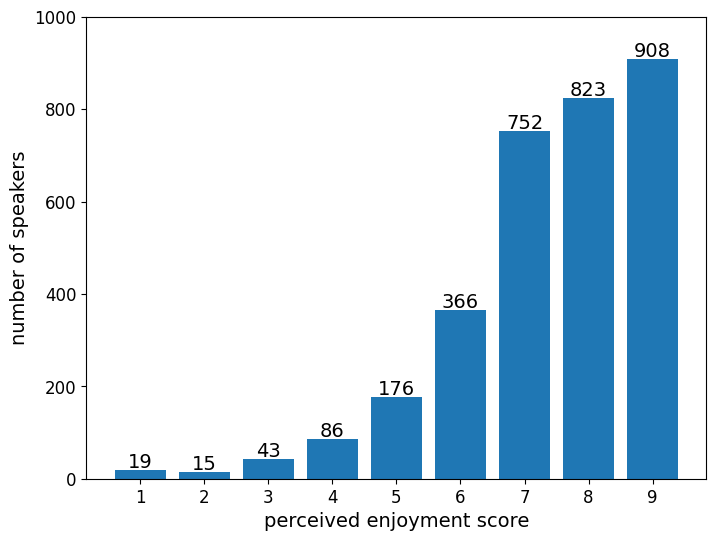

In [11]:
# Figure 1: We plot the Enjoyment Score Distribution from participants' reported "how_enjoyable" score
enjoyment_ps, enjoyment_ss = [], []
for convo in corpus.iter_conversations():
    if convo.meta['primary_speaker'] == None: continue
    enjoyment_ps.append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['primary_speaker']]])
    enjoyment_ss.append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['secondary_speaker']]])

def plot_element_counts(data_list, x_name, y_name, title, note="", sorted_by=None, y_up=None, y_down=None, x_up=None, x_down=None, plot_name=None):
    counts = Counter(data_list)
    if sorted_by is not None:
        sorted_items = [(element, counts[element]) for element in sorted_by if element in counts]
    else:
        sorted_items = sorted(counts.items())
    elements = [item[0] for item in sorted_items]
    occurrences = [item[1] for item in sorted_items]
    font_size = 14
    plt.figure(figsize=(8, 6))
    plt.bar(elements, occurrences)
    for i in range(len(elements)):
      plt.text(elements[i], occurrences[i]+5, str(occurrences[i]), ha='center', fontsize=font_size)

    plt.xlabel(x_name, fontsize=font_size)
    plt.ylabel(y_name, fontsize=font_size)
    plt.title(title, fontsize=font_size)
    plt.xticks(elements, fontsize=font_size - 2)
    plt.yticks(fontsize=font_size - 2)

    plt.text(0, -0.2, note, transform=plt.gca().transAxes, fontsize=font_size, ha='left', va='top')
    if y_up is not None and y_down is not None:
        plt.ylim(y_down, y_up)
    if x_up is not None and x_down is not None:
        plt.xlim(x_down, x_up)
    if plot_name is not None:
        plt.savefig(plot_name)
    plt.show()

plot_element_counts(enjoyment_ps+enjoyment_ss, "perceived enjoyment score", "number of speakers", "", y_up=1000, y_down=0)

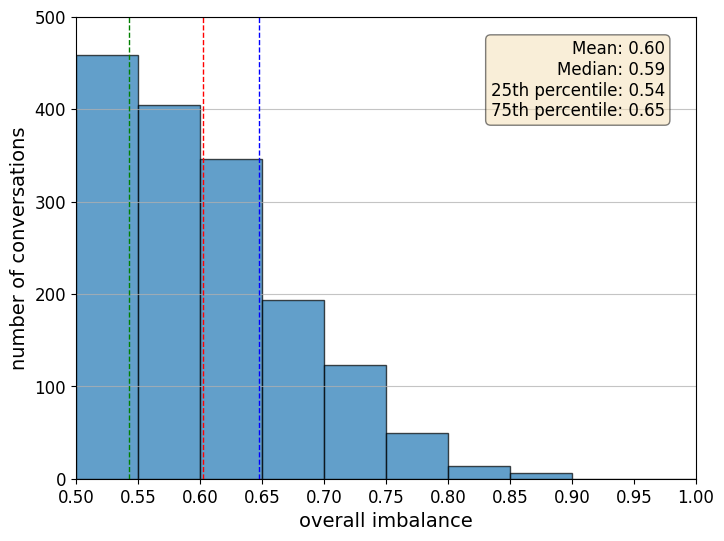

In [83]:
# Figure 2: We plot the overall distribution on the level of imbalanceness across conversations
def check_balance_distribution(corpus, y_up=None):
    balance_score = []
    for convo in corpus.iter_conversations():
        if convo.meta['primary_speaker'] == None: continue
        balance_score.append(convo.meta['balance_score'])

    font_size = 14

    plt.figure(figsize=(8, 6))
    plt.hist(balance_score, bins=np.arange(0, 1.1, 0.05), edgecolor='black', alpha=0.7)
    plt.xlabel('overall imbalance', fontsize=font_size)
    plt.ylabel('number of conversations', fontsize=font_size)
    # plt.title('Distribution of Balance_Score with Preprocessing')
    plt.xticks(np.arange(0, 1.1, 0.05), fontsize=font_size-2)
    plt.yticks(fontsize=font_size - 2)
    plt.grid(axis='y', alpha=0.75)
    plt.ylim(0, 500)
    plt.xlim(0.5, 1.0)

    plt.axvline(np.mean(balance_score), color='r', linestyle='--', linewidth=1, label='Mean')
    plt.axvline(np.percentile(balance_score, 25), color='g', linestyle='--', linewidth=1, label='25th percentile')
    plt.axvline(np.percentile(balance_score, 75), color='b', linestyle='--', linewidth=1, label='75th percentile')


    textstr = f'Mean: {np.mean(balance_score):.2f}\nMedian: {np.median(balance_score):.2f}\n25th percentile: {np.percentile(balance_score, 25):.2f}\n75th percentile: {np.percentile(balance_score, 75):.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=font_size-2,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    if y_up is not None:
        plt.ylim(0, y_up)

    # plt.savefig("plots/balance-distribution.png")
    plt.show()

check_balance_distribution(corpus)

### Categorize Based On Overall Conversation Balance

In [13]:
def get_convo_balance_type(corpus, convo_id):
    """
    We categorize conversation into three types based on the balance score:
    - low_balance: balance score >= 0.65
    - mid_balance: balance score >= 0.55
    - high_balance: balance score >= 0.5
    The thresholds are chosen based on the distribution of balance scores, and 
    can be changed to adapt to different datasets or research questions.
    """
    convo = corpus.get_conversation(convo_id)
    if convo.meta["balance_score"] >= 0.65:
        return 'low_balance'
    elif convo.meta["balance_score"] >= 0.55:
        return 'mid_balance'
    elif convo.meta["balance_score"] >= 0.5:
        return 'high_balance'
    else:
        return 'invalid'

def annotate_conversation_balance_type(corpus):
    for convo in corpus.iter_conversations():
        convo.meta['balance_type'] = get_convo_balance_type(corpus, convo.id)

In [14]:
annotate_conversation_balance_type(corpus)

In [15]:
all_bt = [convo.meta['balance_type'] for convo in corpus.iter_conversations()]
print(f"high_balance: {all_bt.count('high_balance')}, mid_balance: {all_bt.count('mid_balance')}, low_balance: {all_bt.count('low_balance')}")

high_balance: 459, mid_balance: 750, low_balance: 385


In [16]:
# Todo: Add stats of speaker enjoyment score for each balance group, and show that mean is different using mann whitney u test (high vs low)

In [17]:
# Todo: Fighting words between high and low balance groups - Table 2

In [18]:
enjoyment_ps, enjoyment_ss = [], []

balance_to_enjoyment = {}

for convo in corpus.iter_conversations():
    if convo.meta['primary_speaker'] == None: continue
    enjoyment_ps.append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['primary_speaker']]])
    enjoyment_ss.append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['secondary_speaker']]])

    cur_balance = convo.meta['balance_score']
    cur_balance = round((cur_balance * 100) / 5) * 5
    if cur_balance == None: continue
    if cur_balance not in balance_to_enjoyment.keys():
        balance_to_enjoyment.update({cur_balance : {"ps" : [], "ss" : []}})
    balance_to_enjoyment[cur_balance]['ps'].append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['primary_speaker']]])
    balance_to_enjoyment[cur_balance]['ss'].append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['secondary_speaker']]])

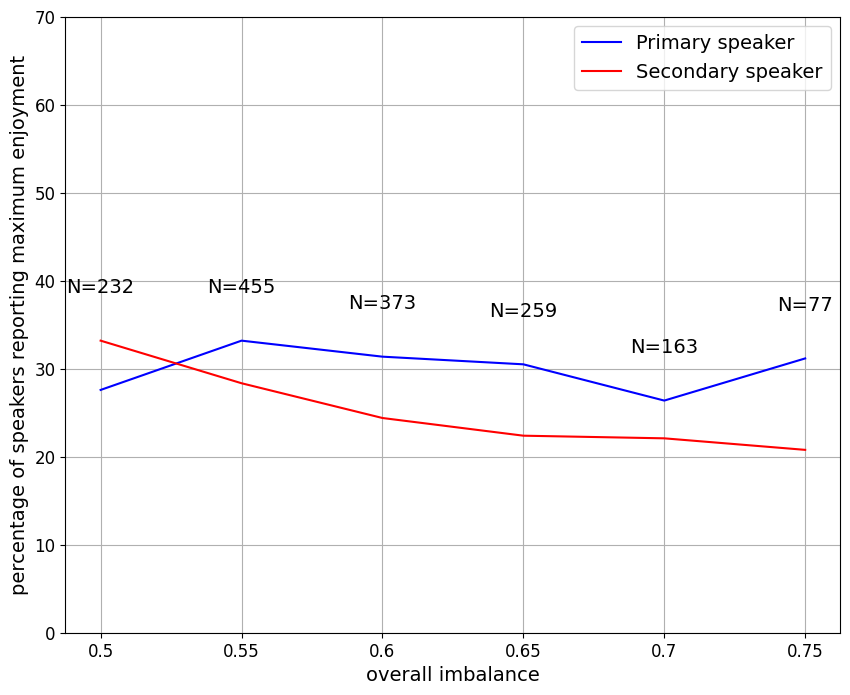

In [19]:
### Figure 3： We plot the percentage of speakers reporting maximum enjoyment (9) at each balance level

selected = [9] # can be changed to [8, 9] or even more ratings

def plot_percentage_speaker_high_enjoy_at_various_balance_level(balance_to_enjoyment, high_enjoy_score=selected, plot_name=None):
    balance_to_enjoyment_exp = {}
    for k, v in balance_to_enjoyment.items():
        balance_to_enjoyment_exp.update({k : {'ps' : 0, 'ss' : 0}})
        for kk, vv in v.items():
            balance_to_enjoyment_exp[k][kk] = percent_A_is_B(vv, high_enjoy_score)

    x_values = [x for x in sorted(list(balance_to_enjoyment_exp.keys())) if x <  80] # below 85
    # x_values = [x for x in sorted(list(balance_to_enjoyment_exp.keys()))]
    ps_values = [balance_to_enjoyment_exp[x]['ps'] for x in x_values]
    ss_values = [balance_to_enjoyment_exp[x]['ss'] for x in x_values]
    x_length = [len(balance_to_enjoyment[x]['ps']) for x in x_values]

    my_x_labels = [str(x/100) for x in x_values]

    ps_values = [val * 100 for val in ps_values]
    ss_values = [val * 100 for val in ss_values]

    font_size = 14

    plt.figure(figsize=(10, 8))
    plt.plot(x_values, ps_values, label='Primary speaker', color='blue')  # Plot 'ps' values
    plt.plot(x_values, ss_values, label='Secondary speaker', color='red')  # Plot 'ss' values
    plt.legend(fontsize=font_size, loc ="upper right")

    for i, label in enumerate(x_length):
        y_offset = max(ps_values[i], ss_values[i]) + 5  # dynamically calculate offset
        plt.text(x_values[i], y_offset, f"N={label}", ha='center', va='bottom', fontsize=font_size)

    plt.xticks(ticks=x_values, labels=my_x_labels, fontsize=font_size - 2)
    # plt.title(f'Primary / Secondary Speaker High Enjoyment (9) percentage at each balance level')
    plt.xlabel('overall imbalance', fontsize=font_size)
    plt.ylabel('percentage of speakers reporting maximum enjoyment', fontsize=font_size)
    plt.yticks(fontsize=font_size-2)
    plt.ylim(0, 70)
    plt.legend()
    plt.grid(True)

    if plot_name is not None:
        plt.savefig(plot_name)

    # Show the plot
    plt.show()

plot_percentage_speaker_high_enjoy_at_various_balance_level(balance_to_enjoyment, high_enjoy_score=selected)

In [20]:
# Todo: Fighting words between Primary and Secondary Speaker - Table 3

In [21]:
# We notice primary and secondary speakers enjoy conversations differently, we do Wilcoxon T-test to check if the difference in distribution of primary / secondary speakers' enjoyment ratings is significant.
# Statistical Test Showing Enjoyment Difference between Primary and Secondary Speaker
stat, p_value = wilcoxon(enjoyment_ps, enjoyment_ss, alternative="greater")
print('Statistics=%.3f, p=%.6f' % (stat, p_value))

Statistics=381024.000, p=0.000431


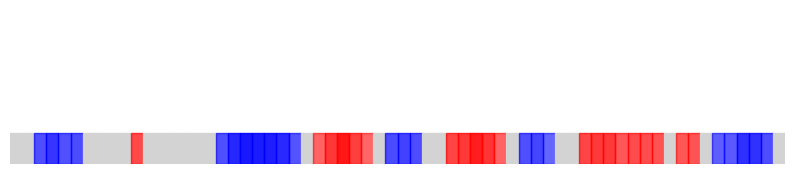

In [22]:
### Figure 4 - A Example plot of a individual conversation's talk-time sharing dynamics
plot_single_conversation_balance(corpus, "a7b14ca1-0b36-42b9-ad4a-50f0eb094035", window_ps_threshold, window_size, sliding_size, remove_first_last_utt, min_utt_words)
# convo = corpus.get_conversation("a7b14ca1-0b36-42b9-ad4a-50f0eb094035")
# print(f"red : {round(convo.meta['percent_red'], 2)}, blue : {round(convo.meta['percent_blue'], 2)}, gray : {round(convo.meta['percent_gray'], 2)}")

## Classify Conversations into Triangle Categories

In [23]:
def floor_lst_parts_percentages(lst):
    count_1 = lst.count(1)
    count_0 = lst.count(0)
    count_neg1 = lst.count(-1)
    total_elements = len(lst)

    percent_1 = (count_1 / total_elements) * 100
    percent_0 = (count_0 / total_elements) * 100
    percent_neg1 = (count_neg1 / total_elements) * 100

    return percent_1, percent_0, percent_neg1

def annotate_convo_RGB_percent(corpus):
    for convo in corpus.iter_conversations():
        percent_1, percent_0, percent_neg1 = floor_lst_parts_percentages(convo.meta['balance_lst'])
        convo.meta['percent_blue'] = percent_1
        convo.meta['percent_gray'] = percent_0
        convo.meta['percent_red'] = percent_neg1

In [24]:
annotate_convo_RGB_percent(corpus)

## A structured Space of Talk-Time Sharing Dynamics

We identify three stereotypes: dominating throughout, back-and-forth, and alternate in dominating. The threshold are picked based on data distributions, and can be adapted to different settings and research questions.

### Triangle 1: (Blue) Dominating Throughout

Here, we define dominating throughout type conversation as having more than 75% of windows as blue windows.

In [25]:
def get_type_dominating_throughout(balance_lst, dominating_throughout_threshold=75):
    if balance_lst == []: return "invalid"
    count_ones = balance_lst.count(1)
    percent_ones = (count_ones / len(balance_lst)) * 100
    count_neg_ones = balance_lst.count(-1)
    percent_neg_ones = (count_neg_ones / len(balance_lst)) * 100
    return percent_ones >= dominating_throughout_threshold or percent_neg_ones >= dominating_throughout_threshold

In [26]:
type_dominating_through = [convo.id for convo in corpus.iter_conversations() if get_type_dominating_throughout(convo.meta['balance_lst'])]
f"Number of Dominating Throughout Conversations: {len(type_dominating_through)}" 

'Number of Dominating Throughout Conversations: 295'

### Triangle 2: (Gray) Back and Forth

We define back and forth type conversation as having more than 60% of windows as gray windows.

In [27]:
def get_type_back_and_forth(balance_lst, back_and_forth_threshold=60):
    if balance_lst == []: return "invalid"
    count_zeros = balance_lst.count(0)
    percent_zeros = (count_zeros / len(balance_lst)) * 100
    return percent_zeros >= back_and_forth_threshold

In [28]:
type_back_and_forth = [convo.id for convo in corpus.iter_conversations() if get_type_back_and_forth(convo.meta['balance_lst'])]
f"Number of Dominating Throughout Conversations: {len(type_back_and_forth)}" 

'Number of Dominating Throughout Conversations: 251'

### Triangle 3: (Red) Alternating Dominance

We define alternating dominance as having more than 25% of windows as red windows.

In [29]:
def get_type_interleaved(balance_lst, red_threshold=25):
    if balance_lst == []: return "invalid"
    count_neg1 = balance_lst.count(-1)
    total_elements = len(balance_lst)
    percent_neg1 = (count_neg1 / total_elements) * 100
    return percent_neg1 > red_threshold

In [30]:
type_interleave = [convo.id for convo in corpus.iter_conversations() if get_type_interleaved(convo.meta['balance_lst']) and not get_type_dominating_throughout(convo.meta['balance_lst'])]
f"Number of Dominating Throughout Conversations: {len(type_interleave)}"

'Number of Dominating Throughout Conversations: 96'

In [31]:
# Annotate Convo Triangle Types
def annotate_convo_triangle_types(corpus):
    count1, count2, count3, count4 = 0, 0, 0, 0
    three_types_dict = {'dominating_throughout' : [], 'back_and_forth' : [], 'interleaved' : [], 'no_label' : []}
    for convo in corpus.iter_conversations():
        balance_lst = convo.meta['balance_lst']
        if get_type_dominating_throughout(balance_lst):
            convo.meta['triangle_type'] = 'dominating_throughout'
            count1 += 1
            three_types_dict['dominating_throughout'].append(convo.id)
        elif get_type_back_and_forth(balance_lst):
            convo.meta['triangle_type'] = "back_and_forth"
            count2 += 1
            three_types_dict['back_and_forth'].append(convo.id)
        elif get_type_interleaved(balance_lst):
            convo.meta['triangle_type'] = 'interleaved'
            count3 += 1
            three_types_dict['interleaved'].append(convo.id)
        else:
            convo.meta['triangle_type'] = None
            count4 += 1
            three_types_dict['no_label'].append(convo.id)
    print(f"Triangle Typology: dominating_throughout: {count1}, back_and_forth: {count2}, interleaved: {count3}, no_label: {count4}")
    return three_types_dict

In [32]:
three_types_dict = annotate_convo_triangle_types(corpus)

Triangle Typology: dominating_throughout: 295, back_and_forth: 251, interleaved: 96, no_label: 952


In [33]:
def get_convo_balance_for_convo_lst(corpus, convo_id_lst):
    return np.mean([corpus.get_conversation(convo_id).meta[f'balance_score'] for convo_id in convo_id_lst])

def get_convo_avg_color_for_convo_lst(corpus, convo_id_lst, color):
    return np.mean([corpus.get_conversation(convo_id).meta[f'percent_{color}'] for convo_id in convo_id_lst])

### Enjoyment score at different stereotypes

In [34]:
# Overall Balance Across stereotypes
for k, v in three_types_dict.items():
    print(f"mean conversation level imbalance for {k}: {round(get_convo_balance_for_convo_lst(corpus, v), 3)}")
print()
for k, v in three_types_dict.items():
    print(f"average color percent for {k}: Blue: {round(get_convo_avg_color_for_convo_lst(corpus, v, 'blue'), 3)}%, Red : {round(get_convo_avg_color_for_convo_lst(corpus, v, 'red'), 3)}%, Gray : {round(get_convo_avg_color_for_convo_lst(corpus, v, 'gray'), 3)}%")

mean conversation level imbalance for dominating_throughout: 0.719
mean conversation level imbalance for back_and_forth: 0.536
mean conversation level imbalance for interleaved: 0.527
mean conversation level imbalance for no_label: 0.592

average color percent for dominating_throughout: Blue: 87.455%, Red : 1.046%, Gray : 11.499%
average color percent for back_and_forth: Blue: 22.536%, Red : 6.699%, Gray : 70.765%
average color percent for interleaved: Blue: 36.138%, Red : 30.774%, Gray : 33.088%
average color percent for no_label: Blue: 50.178%, Red : 9.164%, Gray : 40.658%


In [35]:
# Enjoyment difference between high-balance / high-imbalance conversations
def get_speaker_max_enjoy_percent_convo_lst(corpus, convo_id_lst):
    # Here max enjoyment is 9
    enjoy = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        enjoy += list(convo.meta['how_enjoyable'].values())
    if len(enjoy) == 0:
        return "no convo"
    return enjoy, round(enjoy.count(9) / len(enjoy), 6)*100, round(np.mean(enjoy), 4)

highly_balanced = [convo.id for convo in corpus.iter_conversations() if convo.meta['balance_type'] == 'high_balance']
highly_imbalanced = [convo.id for convo in corpus.iter_conversations() if convo.meta['balance_type'] == 'low_balance']

balance_enjoy, balance_percent, balance_mean = get_speaker_max_enjoy_percent_convo_lst(corpus, highly_balanced)
imbalance_enjoy, imbalance_percent, imbalance_mean = get_speaker_max_enjoy_percent_convo_lst(corpus, highly_imbalanced)

print(f"highly_balanced: percent: {balance_percent}%, mean convo-level imbalance score: {balance_mean}, N of convo = {len(highly_balanced)}")
print(f"highly_imbalanced: percent: {imbalance_percent}%, mean convo-level imbalance score: {imbalance_mean}, N of convo = {len(highly_imbalanced)}\n")

u_statistic, p_value = mannwhitneyu(balance_enjoy, imbalance_enjoy, alternative='two-sided')
print("U Statistic:", u_statistic)
print("P Value:", p_value)

highly_balanced: percent: 31.8083%, mean convo-level imbalance score: 7.5316, N of convo = 459
highly_imbalanced: percent: 25.3247%, mean convo-level imbalance score: 7.2468, N of convo = 385

U Statistic: 391418.0
P Value: 8.992704770891266e-05


### Overall balance distribution across two balanced categories

In [36]:
interleave_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in three_types_dict['interleaved']]
backforth_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in three_types_dict['back_and_forth']]
dominate_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in three_types_dict['dominating_throughout']]

print("mean convo-level imbalance score across stereotypes:")
print(f"\tinterleave: {round(np.mean(interleave_balance),3)}, backforth: {round(np.mean(backforth_balance), 3)}, dominate: {round(np.mean(dominate_balance), 2)}\n")

interleave_enjoy = []
for idx in three_types_dict['interleaved']:
  convo = corpus.get_conversation(idx)
  interleave_enjoy += list(convo.meta['how_enjoyable'].values())
backforth_enjoy = []
for idx in three_types_dict['back_and_forth']:
  convo = corpus.get_conversation(idx)
  backforth_enjoy += list(convo.meta['how_enjoyable'].values())
dominate_enjoy = []
for idx in three_types_dict['dominating_throughout']:
  convo = corpus.get_conversation(idx)
  dominate_enjoy += list(convo.meta['how_enjoyable'].values())

print("mean enjoyment score across stereotypes:")
print(f"\tinterleave: {round(np.mean(interleave_enjoy), 2)}, backforth: {round(np.mean(backforth_enjoy), 2)}, dominate: {round(np.mean(dominate_enjoy), 1)}\n")

print("mann whitney u-test between back-and-forth and alternating-dominance:")
u_statistic, p_value = mannwhitneyu(interleave_enjoy, backforth_enjoy, alternative='two-sided')
print("\tU Statistic:", u_statistic)
print("\tP Value:", p_value)

print("\nmann whitney u-test between back-and-forth and dominating-throughout:")
u_statistic, p_value = mannwhitneyu(backforth_enjoy, dominate_enjoy, alternative='two-sided')
print("\tU Statistic:", u_statistic)
print("\tP Value:", p_value)

mean convo-level imbalance score across stereotypes:
	interleave: 0.527, backforth: 0.536, dominate: 0.72

mean enjoyment score across stereotypes:
	interleave: 7.79, backforth: 7.26, dominate: 7.2

mann whitney u-test between back-and-forth and alternating-dominance:
	U Statistic: 58215.0
	P Value: 1.2633561981776604e-05

mann whitney u-test between back-and-forth and dominating-throughout:
	U Statistic: 149013.5
	P Value: 0.8554813347177187


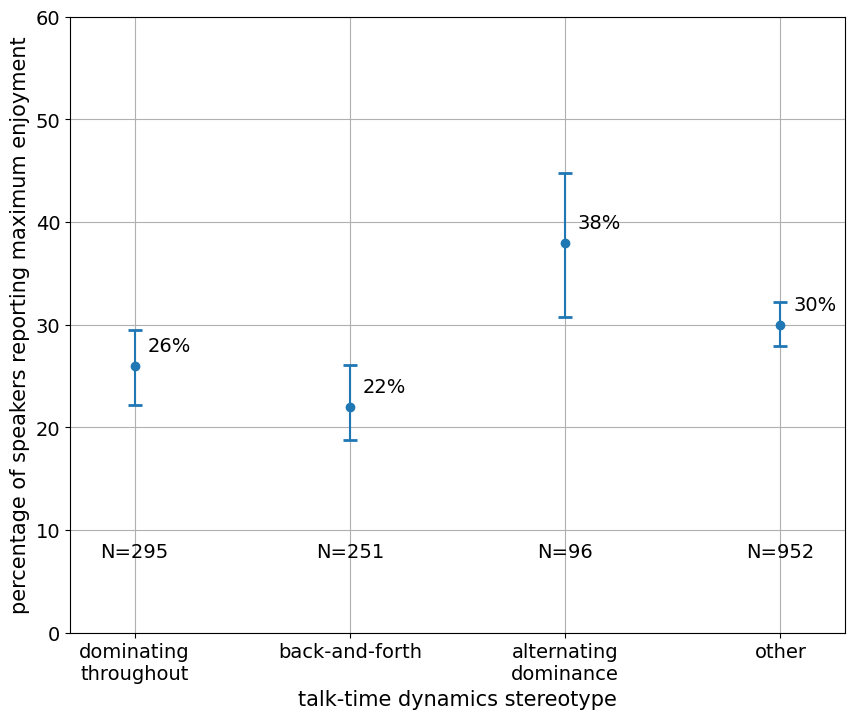

In [37]:
# Figure 5: Enjoyment Percentage at Different stereotypes
cur_balance_type = None
meta_name = "how_enjoyable"

four_types_dict_enjoy_percent = {'dominating_throughout' : [], 'back_and_forth' : [], 'interleaved' : [], 'no_label' : []}

data = three_types_dict

for idx, v in data.items():
  four_types_dict_enjoy_percent[idx] = v

data_dict = four_types_dict_enjoy_percent

x = list(data_dict.keys())
y = [round(get_convo_lst_high_enjoy_percent(corpus, data_dict[key]), 2)*100 for key in x]
num_of_convo = [len(data_dict[key]) for key in x]
y_err = [bootstrap_95_percentage(corpus, data_dict[key]) for key in x]

lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
asymmetric_error = [lower_errors, upper_errors]

x_label = ['dominating\nthroughout', 'back-and-forth', "alternating\ndominance", "other"]

def make_plot(x_label, y, asymmetric_error, plot_name=None):
    plt.figure(figsize=(10, 8))
    plt.errorbar(x_label, y, yerr=asymmetric_error, fmt='o', capsize=5, capthick=2)
    plt.xlabel('talk-time dynamics stereotype', fontsize=15)
    plt.ylabel(f'percentage of speakers reporting maximum enjoyment', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 60)
    plt.xlim(-0.3, len(x_label)-0.7)
    for i, value in enumerate(y):
        plt.text(i+0.16, value + 1, f"{str(int(round(value)))}%", ha='center', va='bottom')

    for i, value in enumerate(y):
        plt.text(i, 7, f"N={str(num_of_convo[i])}", ha='center', va='bottom')
    plt.grid(True)

    if plot_name is not None:
        plt.savefig(plot_name)
    plt.show()

make_plot(x_label, y, asymmetric_error)

In [38]:
# C ontrolled comparison between back-and-forth and alternating dominance stereotypical conversations that are paired by their conversation-level imbalance
def find_closest_pairs(list1, list2, x=0.005):
    list1final = []
    list2final = []
    for dict1 in list1:
      idx1, score1 = next(iter(dict1.items()))
      closest_dict = None
      min_diff = float('inf')
      for dict2 in list2:
          idx2, score2 = next(iter(dict2.items()))
          diff = abs(score1 - score2)
          if diff < min_diff:
              min_diff = diff
              closest_dict = dict2
      if min_diff > x: continue
      idxf, scoref = next(iter(closest_dict.items()))
      list1final.append(idx1)
      list2final.append(idxf)
      list2.remove(closest_dict)

    return list1final, list2final

interleave_balance = [{idx : corpus.get_conversation(idx).meta['balance_score']} for idx in three_types_dict['interleaved']]
backforth_balance = [{idx : corpus.get_conversation(idx).meta['balance_score']} for idx in three_types_dict['back_and_forth']]
# print(len(interleave_balance), len(backforth_balance))
# random.shuffle(interleave_balance)
# random.shuffle(backforth_balance)
control_interleave, control_backforth = find_closest_pairs(interleave_balance, backforth_balance)
print(f"Number of pairs found: {len(control_interleave)}")
control_interleave_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in control_interleave]
control_backforth_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in control_backforth]
u_statistic, p_value = wilcoxon(control_interleave_balance, control_backforth_balance, alternative='two-sided')
print("Balance p-value:")
print("\tU Statistic:", u_statistic)
print("\tP Value:", p_value)
# print(len(control_interleave), len(control_backforth))
control_interleave_enjoy = []
for idx in control_interleave:
  convo = corpus.get_conversation(idx)
  control_interleave_enjoy += list(convo.meta['how_enjoyable'].values())
control_backforth_enjoy = []
for idx in control_backforth:
  convo = corpus.get_conversation(idx)
  control_backforth_enjoy += list(convo.meta['how_enjoyable'].values())
u_statistic, p_value = wilcoxon(control_interleave_enjoy, control_backforth_enjoy, alternative='two-sided')
print("Enjoyment p-value:")
print("\tU Statistic:", u_statistic)
print("\tP Value:", p_value)

Number of pairs found: 93
Balance p-value:
	U Statistic: 1975.0
	P Value: 0.4199255535954207
Enjoyment p-value:
	U Statistic: 3837.0
	P Value: 0.020640740356370518


In [39]:
# Todo: Fighting words between Back-and-Forth and Alternating Dominance - Table 4

### Moving Along Axis

#### Fix Blue
We notice that, if we set a fixed value for the percentage of one color in the conversation (for example, blue), the rest of the conversation can be either red windows or gray windows, as they sum to 100%. Let's analyze how we fix the level of Blue windows in conversations, and see if there is anything different when the rest of the conversation is filled by red windows and gray windows.

In [40]:
def get_convo_lst_enjoy_per(corpus, convo_id_lst):
    enjoy = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        enjoy += list(convo.meta['how_enjoyable'].values())
    if len(enjoy) == 0:
        return "no convo"
    return enjoy.count(9) / len(enjoy)

In [41]:
blue_below_50 = [convo.id for convo in corpus.iter_conversations() if convo.meta['percent_blue'] < 50]
fix_red_level_groups = {"0_10" : [], "10_20" : [], "20_30" : [], "30_40" : [], "40_50" : []}

def get_bin_red(percent_red):
    if 0 <= percent_red < 10:
        return "0_10"
    elif 10 <= percent_red < 20:
        return "10_20"
    elif 20 <= percent_red < 30:
        return "20_30"
    elif 30 <= percent_red < 40:
        return "30_40"
    elif 40 <= percent_red < 50:
        return "40_50"
    else:
        return None

for convo_id in blue_below_50:
    # if convo_id in invalid_convo: continue
    convo = corpus.get_conversation(convo_id)
    bin_id = get_bin_red(convo.meta['percent_red'])
    if bin_id in fix_red_level_groups.keys():
        fix_red_level_groups[bin_id].append(convo.id)

def get_avg_convo_percent_blue(corpus, convo_id_lst):
    percent_blues = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        percent_blues.append(convo.meta['percent_blue'])
    if len(percent_blues) == 0:
        return "no convo"
    return round(sum(percent_blues) / len(percent_blues), 2)

In [42]:
x = list(fix_red_level_groups.keys())
y = [round(get_convo_lst_enjoy_per(corpus, fix_red_level_groups[x[i]]),4)*100 for i in range(len(x))]
y_err = [bootstrap_95_percentage(corpus, fix_red_level_groups[key]) for key in x]

lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
asymmetric_error = [lower_errors, upper_errors]

num_of_convo = [len(fix_red_level_groups[a]) for a in x]

x_names = ["0-10", "10-20", "20-30", "30-40", "40-50"]
x = [x_names[i] for i in range(len(x))]
y = [round(y[i],2) for i in range(len(x))]


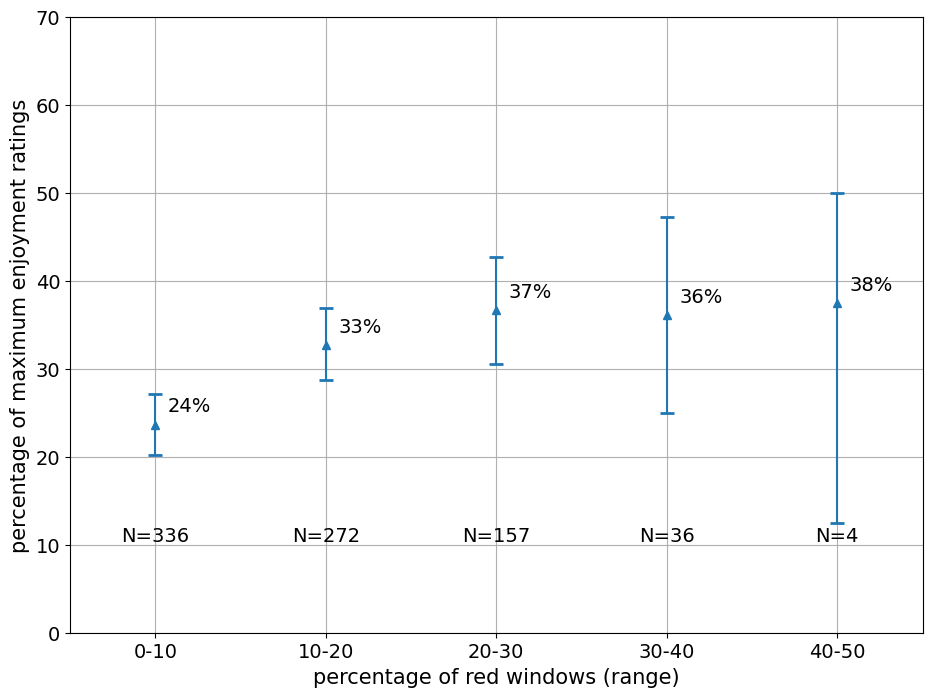

In [43]:
plt.figure(figsize=(11, 8))
plt.errorbar(x_names, y, yerr=asymmetric_error, fmt='^', capsize=5, capthick=2)
plt.xlabel('percentage of red windows (range)', fontsize=15)
plt.ylabel(f'percentage of maximum enjoyment ratings', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for i, value in enumerate(y):
    plt.text(i+0.2, value + 1, f"{str(int(round(value)))}%", ha='center', va='bottom')

for i, value in enumerate(y):
    plt.text(i, 10, f"N={str(num_of_convo[i])}", ha='center', va='bottom')

plt.ylim(0, 70)
plt.xlim(-0.5, len(x_names) - 0.5)
plt.grid(True)
plt.show()

#### Fix Red

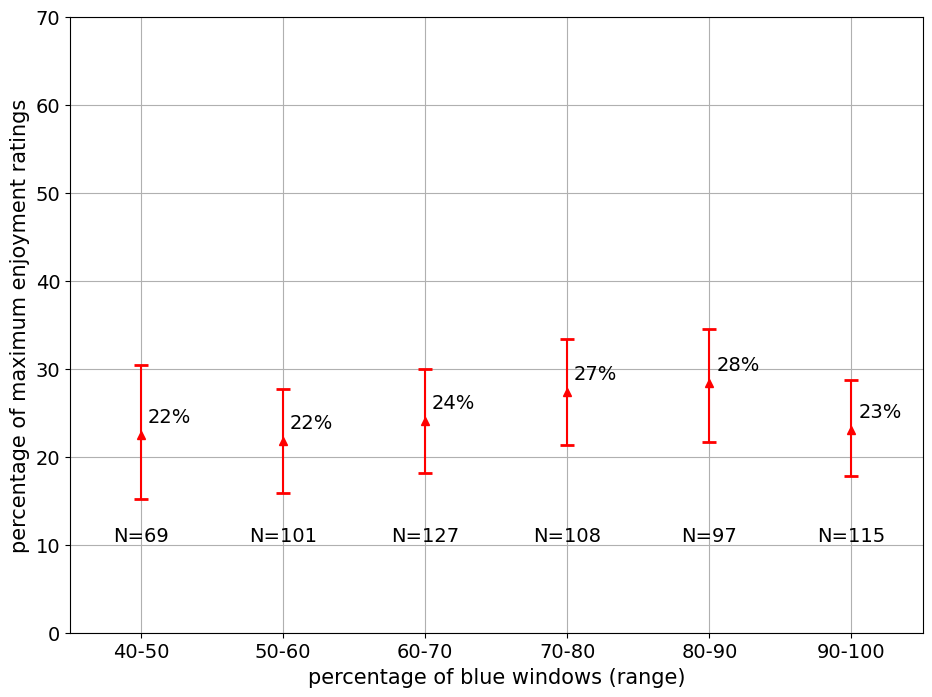

In [44]:
red_below_5 = [convo.id for convo in corpus.iter_conversations() if convo.meta['percent_red'] < 5]

def get_bin_blue(percent_blue):
    if 30 <= percent_blue < 40:
        return "30_40"
    elif 40 <= percent_blue < 50:
        return "40_50"
    elif 50 <= percent_blue < 60:
        return "50_60"
    elif 60 <= percent_blue < 70:
        return "60_70"
    elif 70 <= percent_blue < 80:
        return "70_80"
    elif 80 <= percent_blue < 90:
        return "80_90"
    elif 90 <= percent_blue <= 100:
        return "90_100"
    else:
        return None

def get_avg_convo_percent_red(corpus, convo_id_lst):
    percent_reds = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        percent_reds.append(convo.meta['percent_red'])
    if len(percent_reds) == 0:
        return "no convo"
    return round(sum(percent_reds) / len(percent_reds), 2)

fix_blue_level_groups = {"40_50" : [], "50_60" : [], "60_70" : [], "70_80" : [], "80_90" : [], "90_100" :[]}

for convo_id in red_below_5:
    convo = corpus.get_conversation(convo_id)
    bin_id = get_bin_blue(convo.meta['percent_blue'])
    if bin_id in fix_blue_level_groups.keys():
        fix_blue_level_groups[bin_id].append(convo.id)

def make_plot():
    cur_datadict = fix_blue_level_groups

    x = list(cur_datadict.keys())
    y = [round(get_convo_lst_enjoy_per(corpus, cur_datadict[x[i]]),4)*100 for i in range(len(x))]
    y_err = [bootstrap_95_percentage(corpus, cur_datadict[key]) for key in x]

    lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
    upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
    asymmetric_error = [lower_errors, upper_errors]

    num_of_convo = [len(cur_datadict[a]) for a in x]

    x_names = ["40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]
    x = [x_names[i] for i in range(len(x))]
    y = [round(y[i],2) for i in range(len(x))]

    plt.figure(figsize=(11, 8))
    plt.errorbar(x_names, y, yerr=asymmetric_error, fmt='^', capsize=5, capthick=2, color='red')
    plt.xlabel('percentage of blue windows (range)', fontsize=15)
    plt.ylabel(f'percentage of maximum enjoyment ratings', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    for i, value in enumerate(y):
        plt.text(i+0.2, value + 1, f"{str(int(round(value)))}%", ha='center', va='bottom')

    for i, value in enumerate(y):
        plt.text(i, 10, f"N={str(num_of_convo[i])}", ha='center', va='bottom')

    plt.ylim(0, 70)
    plt.xlim(-0.5, len(x_names) - 0.5)
    plt.grid(True)
    plt.show()

make_plot()


#### Fix gray

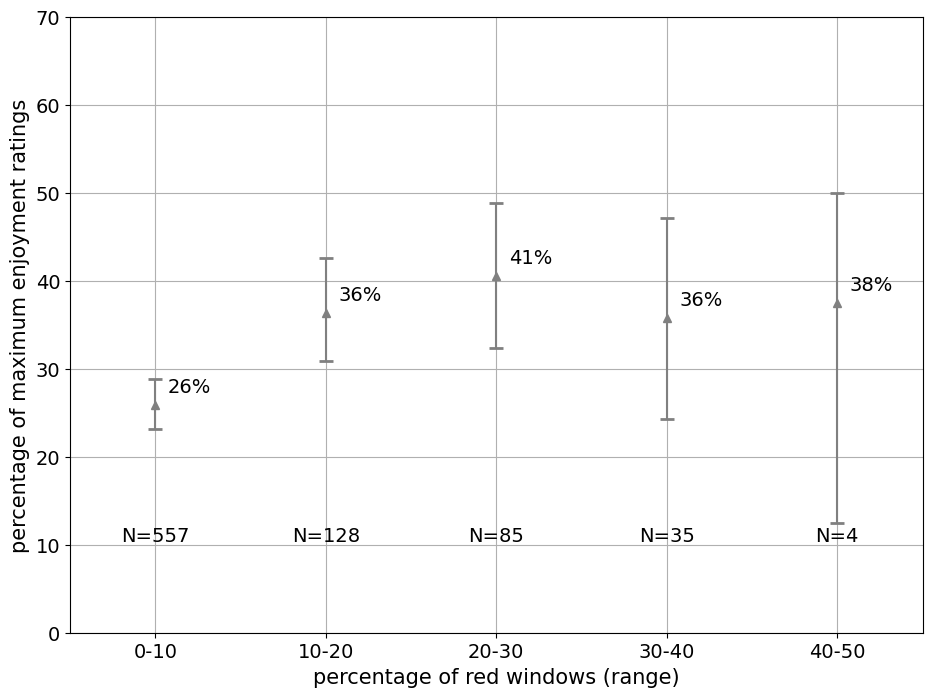

In [45]:
gray_below_40 = [convo.id for convo in corpus.iter_conversations() if convo.meta['percent_gray'] < 40]

fix_red_level_groups = {"0_10" : [], "10_20" : [], "20_30" : [], "30_40" : [], "40_50" : []}

for convo_id in gray_below_40:
    convo = corpus.get_conversation(convo_id)
    bin_id = get_bin_red(convo.meta['percent_red'])
    if bin_id in fix_red_level_groups.keys():
        fix_red_level_groups[bin_id].append(convo.id)

def get_avg_convo_percent_gray(corpus, convo_id_lst):
    percent_grays = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        percent_grays.append(convo.meta['percent_gray'])
    if len(percent_grays) == 0:
        return "no convo"
    return round(sum(percent_grays) / len(percent_grays), 2)

def make_plot():
    cur_datadict = fix_red_level_groups

    x = list(cur_datadict.keys())
    y = [round(get_convo_lst_enjoy_per(corpus, cur_datadict[x[i]]),4)*100 for i in range(len(x))]
    y_err = [bootstrap_95_percentage(corpus, cur_datadict[key]) for key in x]

    lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
    upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
    asymmetric_error = [lower_errors, upper_errors]

    num_of_convo = [len(cur_datadict[a]) for a in x]

    x_names = ["0-10", "10-20", "20-30", "30-40", "40-50"]
    x = [x_names[i] for i in range(len(x))]
    y = [round(y[i],2) for i in range(len(x))]

    plt.figure(figsize=(11, 8))
    plt.errorbar(x_names, y, yerr=asymmetric_error, fmt='^', capsize=5, capthick=2, color='gray')
    plt.xlabel('percentage of red windows (range)', fontsize=15)
    plt.ylabel(f'percentage of maximum enjoyment ratings', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    for i, value in enumerate(y):
        plt.text(i+0.2, value + 1, f"{str(int(round(value)))}%", ha='center', va='bottom')

    for i, value in enumerate(y):
        plt.text(i, 10, f"N={str(num_of_convo[i])}", ha='center', va='bottom')

    plt.ylim(0, 70)
    plt.xlim(-0.5, len(x_names) - 0.5)
    plt.grid(True)
    plt.show()

make_plot()

### Flips
We analyze the changes in dominant speakers during the conversation, with our proposed methods.

In [46]:
# Annotate Number of Flips in each convo

def count_flips_sequence_ratio(sequence_lst):
    count_flips = 0
    total_pairs = 0

    for i in range(len(sequence_lst) - 1):
        if (sequence_lst[i], sequence_lst[i + 1]) in [(1, -1), (-1, 1)]:
            count_flips += 1
        total_pairs += 1

    ratio = count_flips / total_pairs if total_pairs > 0 else 0
    return ratio, count_flips

def remove_short_zero_sequences(input_list, threshold=1000):
    result = []
    i = 0
    while i < len(input_list):
        if input_list[i] == 0:
            start = i
            while i < len(input_list) and input_list[i] == 0:
                i += 1
            if i - start > threshold:
                result.extend([0] * (i - start))
        else:
            result.append(input_list[i])
            i += 1
    return result

def sequence_elements_and_counts(input_list):
    if not input_list:
        return [], []

    elements = [input_list[0]]
    counts = [1]

    for value in input_list[1:]:
        if value == elements[-1]:
            counts[-1] += 1
        else:
            elements.append(value)
            counts.append(1)

    return elements, counts

def remove_short_sequence(sequence_lst, count_lst, threshold=2):
    result_lst = []
    for i in range(len(sequence_lst)):
        count = count_lst[i]
        if count > threshold:
            if len(result_lst) > 0:
                if sequence_lst[i] != result_lst[-1]:
                    result_lst.append(sequence_lst[i])
            else:
                result_lst.append(sequence_lst[i])
    return result_lst

def annotate_convo_flips(corpus):
    for convo in corpus.iter_conversations():
        floor_lst = convo.meta['balance_lst']
        floor_lst = remove_short_zero_sequences(floor_lst)
        floor_sequence, floor_count = sequence_elements_and_counts(floor_lst)
        flip_ratio, flip_count = count_flips_sequence_ratio(floor_sequence)
        convo.meta['flip_count'] = flip_count

In [47]:
annotate_convo_flips(corpus)

In [48]:
flip_lst = [convo.meta['flip_count'] for convo in corpus.iter_conversations()]

### Enjoyment Analysis - Paired test

We match each single-flip conversation with one that has 3 or more flips, such that they have the same proportion of blue, red, and gray windows (with a tolerance of 2%). Then, we compare the enjoyment score between the pairs.

In [49]:
def find_closest_pairs(list1, list2, x=0.01):
    list1final = []
    list2final = []
    for dict1 in list1:
      idx1, score1 = next(iter(dict1.items()))
      closest_dict = None
      min_diff = float('inf')
      for dict2 in list2:
          idx2, score2 = next(iter(dict2.items()))
          diff = abs(score1 - score2)
          if diff < min_diff:
              min_diff = diff
              closest_dict = dict2
      if min_diff > x: continue
      idxf, scoref = next(iter(closest_dict.items()))
      list1final.append(idx1)
      list2final.append(idxf)
      list2.remove(closest_dict)

    return list1final, list2final

In [50]:
tolerance = 2
def pair_elements_blue_red(list1, list2, tolerance=tolerance):
    pairs = []
    used_ids_in_list2 = set()
    for elem1 in list1:
        id1, (value1_1, value2_1) = next(iter(elem1.items()))
        best_match = None
        best_distance = float('inf')
        for elem2 in list2:
            id2, (value1_2, value2_2) = next(iter(elem2.items()))
            if id2 in used_ids_in_list2:
                continue
            distance1 = abs(value1_1 - value1_2)
            distance2 = abs(value2_1 - value2_2)
            if distance1 <= tolerance and distance2 <= tolerance:
                total_distance = distance1 + distance2
                if total_distance < best_distance:
                    best_distance = total_distance
                    best_match = id2
        if best_match is not None:
            pairs.append((id1, best_match))
            used_ids_in_list2.add(best_match)

    return [x[0] for x in pairs], [x[1] for x in pairs]

In [51]:
random.seed(42)
num_pairs_found = []
b_u_stats = []
b_p_values = []
en_u_stats = []
en_p_values = []
en_score_1 = []
en_score_3 = []
percent_1 = []
percent_3 = []

# for i in range(500):
flip_1 = [{convo.id : [convo.meta['percent_blue'], convo.meta['percent_red']]} for convo in corpus.iter_conversations() if convo.meta['flip_count'] == 1]
flip_3 = [{convo.id : [convo.meta['percent_blue'], convo.meta['percent_red']]} for convo in corpus.iter_conversations() if convo.meta['flip_count'] >= 3]
flip_1 = random.sample(flip_1, len(flip_1))
flip_3 = random.sample(flip_3, len(flip_3))
# print(f"Overall: {len(flip_1)} with 1 flip, {len(flip_3)} with 3+ flips")

control_flip_1, control_flip_3 = pair_elements_blue_red(flip_1, flip_3)
num_pairs_found.append(len(control_flip_1))


control_flip_1_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in control_flip_1]
control_flip_3_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in control_flip_3]
u_statistic, p_value = mannwhitneyu(control_flip_1_balance, control_flip_3_balance, alternative='two-sided')
b_u_stats.append(u_statistic)
b_p_values.append(p_value)


control_flip_1_enjoy = []
for idx in control_flip_1:
  convo = corpus.get_conversation(idx)
  control_flip_1_enjoy += list(convo.meta['how_enjoyable'].values())
control_flip_3_enjoy = []
for idx in control_flip_3:
  convo = corpus.get_conversation(idx)
  control_flip_3_enjoy += list(convo.meta['how_enjoyable'].values())
u_statistic, p_value = mannwhitneyu(control_flip_1_enjoy, control_flip_3_enjoy, alternative='two-sided')
en_u_stats.append(u_statistic)
en_p_values.append(p_value)
en_score_1.append(np.mean(control_flip_1_enjoy))
en_score_3.append(np.mean(control_flip_3_enjoy))

count_1 = 0
count_3 = 0
for i in range(len(control_flip_1)):
  convo1 = corpus.get_conversation(control_flip_1[i])
  convo3 = corpus.get_conversation(control_flip_3[i])
  if sum(list(convo1.meta['how_enjoyable'].values())) > sum(list(convo3.meta['how_enjoyable'].values())):
    count_1 += 1
  elif sum(list(convo1.meta['how_enjoyable'].values())) < sum(list(convo3.meta['how_enjoyable'].values())):
    count_3 += 1

percent_1.append(count_1 / len(control_flip_1))
percent_3.append(count_3 / len(control_flip_3))


print(f"We found {np.mean(num_pairs_found)} pairs with toleration {tolerance}\n")
print("Balance score between two groups (mannwhitneyu):")
print("\tU Statistic:", np.mean(b_u_stats))
print("\tP Value:", np.mean(b_p_values))
print("\nEnjoyable score between two groups (mannwhitneyu):")
print("\tU Statistic:", np.mean(en_u_stats))
print("\tP Value:", np.mean(en_p_values))
print(f"\nEnjoy: with 1 flip {np.mean(en_score_1)}")
print(f"Enjoy: with 3+ flip {np.mean(en_score_3)}")
print(f"\nwith 1 flip higher enjoy: {round(np.mean(percent_1), 4)}%, with 3+ flip {round(np.mean(percent_3), 4)}%")

We found 90.0 pairs with toleration 2

Balance score between two groups (mannwhitneyu):
	U Statistic: 3866.0
	P Value: 0.5995952992175173

Enjoyable score between two groups (mannwhitneyu):
	U Statistic: 14893.0
	P Value: 0.1739577730491806

Enjoy: with 1 flip 7.166666666666667
Enjoy: with 3+ flip 7.377777777777778

with 1 flip higher enjoy: 0.3778%, with 3+ flip 0.5333%


### Capture Mixed Stereotype Conversations

In [52]:
def get_first_second_half_convo(corpus, convo_id):
    convo = corpus.get_conversation(convo_id)
    balance_lst = convo.meta['balance_lst']
    return balance_lst[:int(len(balance_lst)*0.6)], balance_lst[int(len(balance_lst)*0.4):]

def get_type_dominating_throughout(balance_lst, dominating_throughout_threshold=75):
    if balance_lst == []: return "invalid"
    count_ones = balance_lst.count(1)
    percent_ones = (count_ones / len(balance_lst)) * 100
    count_neg_ones = balance_lst.count(-1)
    percent_neg_ones = (count_neg_ones / len(balance_lst)) * 100
    return percent_ones >= dominating_throughout_threshold or percent_neg_ones >= dominating_throughout_threshold

def get_type_back_and_forth(balance_lst, back_and_forth_threshold=60):
    if balance_lst == []: return "invalid"
    count_zeros = balance_lst.count(0)
    percent_zeros = (count_zeros / len(balance_lst)) * 100
    return percent_zeros >= back_and_forth_threshold

def get_type_interleaved(balance_lst, red_threshold=25):
    if balance_lst == []: return "invalid"
    count_neg1 = balance_lst.count(-1)
    total_elements = len(balance_lst)
    percent_neg1 = (count_neg1 / total_elements) * 100
    return percent_neg1 > red_threshold

def get_lst_balance_type(lst):
    if get_type_interleaved(lst):
        return "interleaved"
    elif get_type_dominating_throughout(lst):
        return "dominating_throughout"
    elif get_type_back_and_forth(lst):
        return "back_and_forth"
    else:
        return None
    
def get_mixed_stereotype_conversation(corpus, convo_id):
    first, second = get_first_second_half_convo(corpus, convo_id)
    first_type = get_lst_balance_type(first)
    second_type = get_lst_balance_type(second)
    if first_type is None or second_type is None:
        return None
    if first_type != second_type:
        return [first_type, second_type]
    else:
        return [first_type]

In [53]:
mixed_convos = {}
count = 0
for convo in corpus.iter_conversations():
    convo_type = get_mixed_stereotype_conversation(corpus, convo.id)
    if convo_type is not None and len(convo_type) == 2:
        mixed_convos.update({convo.id : convo_type})
        count += 1
        convo.meta["mixed"] = True
    else:
        convo.meta['mixed'] = False
count

47

In [54]:
def count_unique_values(input_dict):
    value_counts = Counter(tuple(v) for v in input_dict.values())
    return dict(value_counts)

mixed_convos_plot_dict = {}
for k, v in mixed_convos.items():
    key = v[0]+v[1]
    if key not in mixed_convos_plot_dict.keys():
        mixed_convos_plot_dict.update({key : []})
    mixed_convos_plot_dict[key].append(k)
# for k, v in mixed_convos_plot_dict.items():
#     print(k, len(v))

count_unique_values(mixed_convos)

{('back_and_forth', 'dominating_throughout'): 11,
 ('back_and_forth', 'interleaved'): 13,
 ('interleaved', 'dominating_throughout'): 6,
 ('interleaved', 'back_and_forth'): 13,
 ('dominating_throughout', 'interleaved'): 4}

In [55]:
labels = ["back_and_forthdominating_throughout", "back_and_forthinterleaved", "interleaveddominating_throughout", "interleavedback_and_forth", "dominating_throughoutinterleaved"]
names = ["bf-dt", "bf-ad", "ad-dt", "ad-bf", "dt-ad"]
# for i, label in enumerate(labels):
#     plot_multi_conversation_balance(corpus, mixed_convos_plot_dict[label])

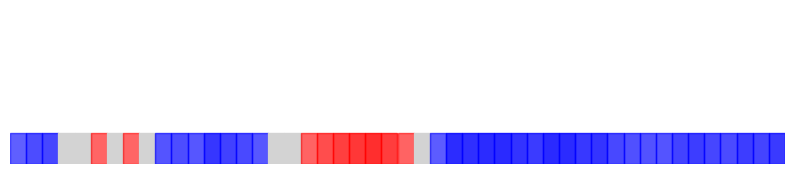

red : 18.75, blue : 66.67, gray : 14.58


In [56]:
plot_single_conversation_balance(corpus, mixed_convos_plot_dict["interleaveddominating_throughout"][0], window_ps_threshold, window_size, sliding_size, remove_first_last_utt, min_utt_words)

# Demo 2: Talk-Time Sharing Dynamics in Supreme Court Oral Argument Conversations

Here, we demonstrate the use of our proposed computational approach in a new distinct data setting: [the Supreme Court oral arguments](https://convokit.cornell.edu/documentation/supreme.html). The conversations are now not dyadic, and not role neutral. We show that with some simple changes, we can adapt our method to analyze the talk-time sharing dynamics in this new data setting.

In [ ]:
### Download the data to your directory or load the data
SUPREME_DATA_PATH = "/Users/seanzhangkx/Desktop/Research/SupremeCourtData/"
# supreme_corpus = Corpus(filename=download("supreme-corpus", data_dir=SUPREME_DATA_PATH))
supreme_corpus = Corpus(filename=SUPREME_DATA_PATH)

## Processing the data

We used the Supreme Court Oral Arguments dataset, where each case are conversations between lawyers and judges, and the lawyers can be from petitioner side and respondent side. We treat all the lawyers from one side as a single speaker, as well as all of the justices. Utterance timestamps enabled us to compute talk-time dynamics. We applied asymmetric dominance thresholds and analyzed patterns against case outcomes.

In [58]:
### Annotate dataset
for utt in supreme_corpus.iter_utterances():
    utt.meta['start'] = utt.meta['start_times'][0]
    utt.meta['stop'] = utt.meta['stop_times'][-1]

In [59]:
### We find differnent voting types at the end of the conversation for each case in the supreme court dataset.
def check_proportion(lst, threshold=2):
    count_0 = lst.count(0)
    count_1 = lst.count(1)
    if count_0 >= threshold and count_1 >= threshold:
        return True
    else:
        return False

def check_all_agree(lst):
    return len(set(lst)) == 1

convo_vote_agreement = {"disagree" : [], "mixed" : [], "all_agree" : [], "others" : []}

for convo in supreme_corpus.iter_conversations():
    if convo.meta['votes_side'] is None: continue
    votes_side = convo.meta['votes_side']
    votes = list(votes_side.values())
    if check_proportion(votes, threshold=4):
        convo.meta['agreement_type'] = "disagree"
        convo_vote_agreement["disagree"].append(convo.id)
    elif check_proportion(votes, threshold=2):
        convo.meta['agreement_type'] = "mixed"
        convo_vote_agreement["mixed"].append(convo.id)
    elif check_all_agree(votes):
        convo.meta['agreement_type'] = "all_agree"
        convo_vote_agreement["all_agree"].append(convo.id)
    else:
        convo.meta['agreement_type'] = "others"
        convo_vote_agreement["others"].append(convo.id)

print(f"disagree : {len(convo_vote_agreement['disagree'])}, mixed : {len(convo_vote_agreement['mixed'])}, all_agree : {len(convo_vote_agreement['all_agree'])}, others : {len(convo_vote_agreement['others'])}")

disagree : 1356, mixed : 2624, all_agree : 2946, others : 878


In [60]:
def find_valid_conversation(corpus, convo_lst):
    """
    Find valid conversations based on the following criteria:
    1. Each side must have one and only one advocate.
    2. The conversation must have more than one utterance.
    3. The conversation must be at least 15 minutes long.
    4. Each utterance must have a valid start and stop time.
    """
    valid_convo = []
    for convo_id in convo_lst:
        convo = corpus.get_conversation(convo_id)
        side1 = []
        side2 = []
        for utt in convo.iter_utterances():
            if utt.meta['side'] == 1:
                side1.append(utt.speaker.id)
            elif utt.meta['side'] == 0:
                side2.append(utt.speaker.id)
        # if more than 1 advocates speak for one side, filter out
        if len(set(side1)) > 1 or len(set(side2)) > 1:
            continue
        # if convo doesn't have advocates on each side, filter out
        elif len(set(side1)) == 0 or len(set(side2)) == 0:
            continue
            
        utt_lst = convo.get_utterance_ids()
        # if only one utt or convo less than 15 min, filter out
        if len(utt_lst) == 1:
            continue
        last_utt = corpus.get_utterance(utt_lst[-1])
        if last_utt.meta['stop'] == 0 or last_utt.meta['stop'] < 15*60:
            continue
        # if there is invalid utt, filter out
        valid = True
        for utt_id in utt_lst:
            utt = corpus.get_utterance(utt_id)
            if utt.meta['stop'] < utt.meta['start']:
                valid = False
                break
        if not valid:
            continue
        valid_convo.append(convo_id)
    return valid_convo

In [ ]:
for k, v in convo_vote_agreement.items():
    convo_vote_agreement[k] = find_valid_conversation(supreme_corpus, v)

for k, v in convo_vote_agreement.items():
    for convo_id in v:
        convo = supreme_corpus.get_conversation(convo_id)
        convo.meta['valid'] = True
    print(f"{k}: {len(v)}")

for convo in supreme_corpus.iter_conversations():
    if 'valid' not in convo.meta.keys():
        convo.meta['valid'] = False

disagree 816
mixed 1498
all_agree 1760
others 454


In [62]:
supreme_corpus = supreme_corpus.filter_conversations_by(lambda convo: convo.meta['valid'])
supreme_corpus.print_summary_stats()

Number of Speakers: 5951
Number of Utterances: 996466
Number of Conversations: 4528


In [63]:
def extract_convo_valid_utterances(corpus, convo):
    utt_lst = convo.get_utterance_ids()
    valid_utt = []
    for i, utt_id in enumerate(utt_lst):
        utt = corpus.get_utterance(utt_id)
        not_valid = True
        if utt.meta['speaker_type'] == 'J':
            not_valid = False
        elif utt.meta['speaker_type'] == 'A':
            if utt.meta['side'] == 0 or utt.meta['side'] == 1:
                not_valid = False
        if not_valid:
            duration = utt.meta['stop'] - utt.meta['start']
            for later_utt_id in utt_lst[i+1:]:
                later_utt = corpus.get_utterance(later_utt_id)
                later_utt.meta['start'] -= duration
                later_utt.meta['stop'] -= duration
        else:
            valid_utt.append(utt)
    return valid_utt

valid_utt = []
for convo in supreme_corpus.iter_conversations():
    valid_utt += extract_convo_valid_utterances(supreme_corpus, convo)

In [64]:
new_corpus = Corpus(utterances=valid_utt)
for convo in new_corpus.iter_conversations():
    convo.meta = supreme_corpus.get_conversation(convo.id).meta
supreme_corpus = new_corpus
supreme_corpus.print_summary_stats()

Number of Speakers: 5825
Number of Utterances: 924745
Number of Conversations: 4528


In [65]:
for utt in supreme_corpus.iter_utterances():
    if utt.meta['start'] < 0 or utt.meta['stop'] < 0 or utt.meta['stop'] - utt.meta['start'] < 0:
        assert False, f"invalid utterance {utt.id}"

In [66]:
def one_convo_to_three_convo(corpus, convo):
    """
    Each conversation in the supreme court dataset is a mix of three conversations.
    Frist conversation is where the petitioner lawyer speaks, second conversation is where the respondent lawyer speaks,
    and the third conversation is where the petitioner lawyer make the rebuttal.
    this function will extract the three conversations from the original conversation.
    """
    first_convo, second_convo, third_convo = [], [], []
    spoken_lawyers = []
    convo_num = 0
    for utt in convo.iter_utterances():
        if convo_num == 0:
            if utt.meta['speaker_type'] == 'A' and (utt.meta['side'] == 0 or utt.meta['side'] == 1):
                spoken_lawyers.append(utt.speaker.id)
                convo_num += 1
                first_convo.append(utt.id)
                
        elif convo_num == 1:
            if utt.speaker.id not in spoken_lawyers and utt.meta['speaker_type'] == 'A' and (utt.meta['side'] == 0 or utt.meta['side'] == 1):
                spoken_lawyers.append(utt.speaker.id)
                convo_num += 1
                second_convo.append(utt.id)
            else:
                first_convo.append(utt.id)

        elif convo_num == 2:
            if utt.speaker.id == spoken_lawyers[0]:
                convo_num += 1
                third_convo.append(utt.id)
            else:
                second_convo.append(utt.id)
             
        elif convo_num == 3:
            third_convo.append(utt.id)

    return first_convo, second_convo, third_convo

In [67]:
for convo in supreme_corpus.iter_conversations():
    one, two, three = one_convo_to_three_convo(supreme_corpus, convo)
    if two == [] and three == []:
        assert False, f"bad conversation {convo.id}"

In [68]:
corpus_one_utt, corpus_two_utt, corpus_three_utt = [], [], []
for convo in supreme_corpus.iter_conversations():
    one, two, three = one_convo_to_three_convo(supreme_corpus, convo)
    corpus_one_utt += [supreme_corpus.get_utterance(utt_id) for utt_id in one]
    corpus_two_utt += [supreme_corpus.get_utterance(utt_id) for utt_id in two]
    corpus_three_utt += [supreme_corpus.get_utterance(utt_id) for utt_id in three]

corpus_one = Corpus(utterances=corpus_one_utt)
corpus_two = Corpus(utterances=corpus_two_utt)
corpus_three = Corpus(utterances=corpus_three_utt)
for convo in corpus_one.iter_conversations():
    convo.meta = supreme_corpus.get_conversation(convo.id).meta
for convo in corpus_two.iter_conversations():
    convo.meta = supreme_corpus.get_conversation(convo.id).meta
for convo in corpus_three.iter_conversations():
    convo.meta = supreme_corpus.get_conversation(convo.id).meta

corpus_one.print_summary_stats()
corpus_two.print_summary_stats()
corpus_three.print_summary_stats()

Number of Speakers: 3143
Number of Utterances: 401499
Number of Conversations: 4528
Number of Speakers: 3398
Number of Utterances: 459722
Number of Conversations: 4528
Number of Speakers: 2797
Number of Utterances: 58583
Number of Conversations: 3878


## Analysis

### Annotate the data with Talk-Time Sharing information

In [69]:
primary_threshold = 0.5000001
# Because of the asymetric nature of the data, we need to set different thresholds for A and J
window_ps_threshold_A = 0.8 
window_ps_threshold_J = 0.4
window_size = 2 # window size in minutes
sliding_size = 30  # sliding window size in sec
cur_cut = 0
remove_first_last_utt = False

In [70]:
def tokenize(text):
    text = text.lower()
    text = re.findall('[a-z]+', text)
    return text

def longer_than_xwords(corpus, utt_id, x=cur_cut):
    utt = corpus.get_utterance(utt_id)
    return len(tokenize(utt.text)) >= x

def rhythm_count_utt_time(corpus, utt_lst, cur_cut=cur_cut):
    valid_utt = [utt_id for utt_id in utt_lst if longer_than_xwords(corpus, utt_id)]
    if len(valid_utt) == 0: return 0, 0
    time_A = 0
    time_B = 0
    for utt_id in valid_utt:
        utt = corpus.get_utterance(utt_id)
        time = utt.meta['stop'] - utt.meta['start']
        if utt.meta['utt_group'] == 'groupA':
            time_A += time
        elif utt.meta['utt_group'] == 'groupB':
            time_B += time
    return time_A, time_B

def get_ps(corpus, utt_lst, primary_threshold=primary_threshold):
    assert primary_threshold > 0.5, "Primary Threshold should greater than 0.5"
    if len(utt_lst) == 0: return None
    time_A, time_B = rhythm_count_utt_time(corpus, utt_lst)
    total_speaking_time = time_A + time_B
    if time_A > (total_speaking_time * primary_threshold):
        return 'groupA'
    elif time_B > (total_speaking_time * primary_threshold):
        return 'groupB'
    else:
        return None

In [71]:
def annotate_groups(corpus):
    # lawyers are groupA, justices are groupB
    for convo in corpus.iter_conversations():
        for utt in convo.iter_utterances():
            if utt.meta['speaker_type'] == 'A':
                utt.meta['utt_group'] = 'groupA'
            elif utt.meta['speaker_type'] == 'J':
                utt.meta['utt_group'] = 'groupB'
            else:
                utt.meta['utt_group'] = 'no_data'

def annotate_primary_speaking_group(corpus):
    for convo in corpus.iter_conversations():
        if remove_first_last_utt:
            utt_lst = convo.get_utterance_ids()[1:-1]
        else:
            utt_lst = convo.get_utterance_ids()
        ps = get_ps(corpus, utt_lst)
        convo.meta['primary_speaker'] = ps
        if ps == None:
            convo.meta['secondary_speaker'] = None
        else:
            ss = 'groupB' if ps == 'groupA' else 'groupA'
            convo.meta['secondary_speaker'] = ss

def annotate_ps_and_utt_groups(corpus):
    annotate_groups(corpus)
    annotate_primary_speaking_group(corpus)

annotate_ps_and_utt_groups(supreme_corpus)
annotate_ps_and_utt_groups(corpus_one)
annotate_ps_and_utt_groups(corpus_two)
annotate_ps_and_utt_groups(corpus_three)

In [72]:
### Annotate winning side of the conversation.
def annotate_win_or_lose(corpus):
    for convo in corpus.iter_conversations():
        win_side = convo.meta['win_side']
        lawyer_side = 0
        for utt in convo.iter_utterances():
            if utt.meta['speaker_type'] == 'A':
                lawyer_side = utt.meta['side']
                break
        convo.meta['win_or_lose'] = win_side == lawyer_side

annotate_win_or_lose(corpus_one)
annotate_win_or_lose(corpus_two)
annotate_win_or_lose(corpus_three)

In [73]:
def sliding_window(corpus, convo_id, window_size=window_size, sliding_size=sliding_size):
    convo = corpus.get_conversation(convo_id)
    if remove_first_last_utt:
        utt_lst = convo.get_utterance_ids()[1:-1]
    else:
        utt_lst = convo.get_utterance_ids()

    all_windows = []

    cur_start_time = corpus.get_utterance(utt_lst[0]).meta['start']
    cur_end_time = cur_start_time + (window_size * 60)
    prev_window_last_utt_id = utt_lst[0]
    convo_end_time = corpus.get_utterance(utt_lst[-1]).meta['stop']

    while prev_window_last_utt_id != utt_lst[-1] and cur_end_time < convo_end_time:
        cur_window_groupA_speaking_time = 0
        cur_window_groupB_speaking_time = 0

        for i, utt_id in enumerate(utt_lst):
            utt = corpus.get_utterance(utt_id)
            # case 1: utterances in previous windows and not in current window at all
            if utt.meta['stop'] < cur_start_time: continue

            # case 2: last utt of the current window
            if utt.meta['stop'] > cur_end_time:
                # the entire utt not in the window, meaning previous utt is in the window and this one is not
                if utt.meta['start'] > cur_end_time:
                    prev_window_last_utt_id = utt_lst[i-1]
                # special case: the utt span longer than the entire window
                elif utt.meta['start'] < cur_start_time:
                    if utt.meta['utt_group'] == 'groupA':
                        cur_window_groupA_speaking_time += cur_end_time - cur_start_time
                    elif utt.meta['utt_group'] == 'groupB':
                        cur_window_groupB_speaking_time += cur_end_time - cur_start_time
                    prev_window_last_utt_id = utt_id
                # part of the utt in the window
                else:
                    if utt.meta['utt_group'] == 'groupA':
                        cur_window_groupA_speaking_time += cur_end_time - utt.meta['start']
                    elif utt.meta['utt_group'] == 'groupB':
                        cur_window_groupB_speaking_time += cur_end_time - utt.meta['start']
                    prev_window_last_utt_id = utt_id
                # put window data in all_windows only at the terminating point: last utt of the window
                all_windows.append({'groupA' : cur_window_groupA_speaking_time, 'groupB' : cur_window_groupB_speaking_time})
                break
            
            # case 3: utterances in the window but not the last utterance of the window
            if utt.meta['stop'] > cur_start_time:
                # part of the utt in window
                if utt.meta['start'] < cur_start_time and utt.meta['stop'] > utt.meta['start']:
                    if utt.meta['utt_group'] == 'groupA':
                        cur_window_groupA_speaking_time += utt.meta['stop'] - cur_start_time
                    elif utt.meta['utt_group'] == 'groupB':
                        cur_window_groupB_speaking_time += utt.meta['stop'] - cur_start_time
                # entire utt in window
                else:
                    if utt.meta['utt_group'] == 'groupA':
                        cur_window_groupA_speaking_time += utt.meta['stop'] - utt.meta['start']
                    elif utt.meta['utt_group'] == 'groupB':
                        cur_window_groupB_speaking_time += utt.meta['stop'] - utt.meta['start']

        # update window start end time
        cur_start_time += sliding_size
        cur_end_time += sliding_size

    return all_windows

def convo_balance_score(corpus, convo_id):
    if remove_first_last_utt:
        utt_lst = corpus.get_conversation(convo_id).get_utterance_ids()[1:-1]
    else:
        utt_lst = corpus.get_conversation(convo_id).get_utterance_ids()
    timeA, timeB = rhythm_count_utt_time(corpus, utt_lst)
    total_time = timeA + timeB
    if total_time == 0:
        print(f" this conversation has no one speaking: {convo_id}")
        return -100
    return timeA / total_time if timeA >= timeB else timeB / total_time

def convo_balance_lst(corpus, convo_id): # new with adjusted hyperparameters
    groups = sliding_window(corpus, convo_id)
    balance_lst = []
    for window in groups:
        window_A_time = window['groupA']
        window_J_time = window['groupB']
        window_total_time = window_A_time + window_J_time
        if window_total_time == 0: # No Speaking Time in the window
            continue
        elif window_A_time > window_total_time * window_ps_threshold_A:
            balance_lst.append(1)
        elif window_J_time > window_total_time * window_ps_threshold_J:
            balance_lst.append(-1)
        else:
            balance_lst.append(0)
    return balance_lst

def annotate_balance(corpus):
    for convo in tqdm(corpus.iter_conversations()):
        balance = convo_balance_score(corpus, convo.id)
        convo.meta['balance_score'] = balance if balance != -1 else None
        balance_lst = convo_balance_lst(corpus, convo.id)
        convo.meta['balance_lst'] = balance_lst

annotate_balance(supreme_corpus)
annotate_balance(corpus_one)
annotate_balance(corpus_two)
annotate_balance(corpus_three)

4528it [01:33, 48.63it/s]
4528it [00:26, 168.98it/s]
4528it [00:32, 139.02it/s]
3878it [00:02, 1442.19it/s]


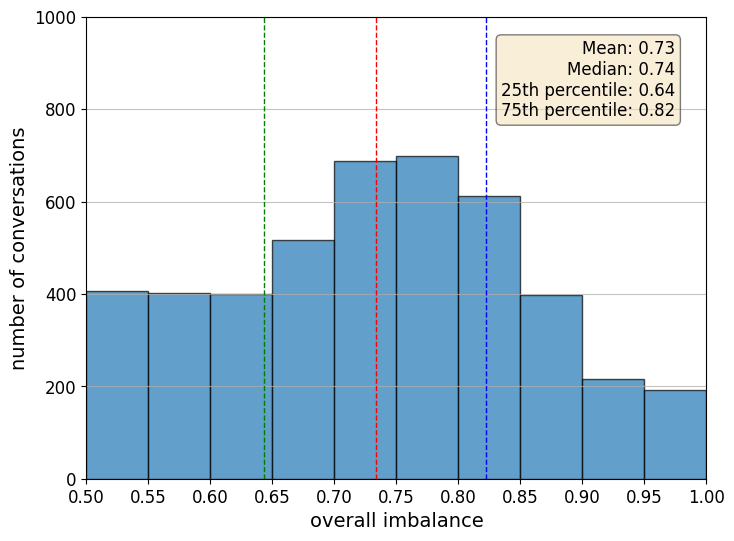

In [85]:
check_balance_distribution(supreme_corpus, y_up=1000)

### Define the stereotypes

We defined stereotypes based on talk-time distribution, labeling a conversation as dominated throughout if more than 70% of windows were blue, alternating dominance if more than 40% were red, and back-and-forth if more than 40% were gray.

In [75]:
def get_type_dominating_throughout(balance_lst, dominating_throughout_threshold=70):
    if balance_lst == []: return "invalid"
    count_ones = balance_lst.count(1)
    percent_ones = (count_ones / len(balance_lst)) * 100
    count_neg_ones = balance_lst.count(-1)
    percent_neg_ones = (count_neg_ones / len(balance_lst)) * 100
    return percent_ones >= dominating_throughout_threshold or percent_neg_ones >= dominating_throughout_threshold

def get_type_back_and_forth(balance_lst, back_and_forth_threshold=40):
    if balance_lst == []: return "invalid"
    count_zeros = balance_lst.count(0)
    percent_zeros = (count_zeros / len(balance_lst)) * 100
    return percent_zeros >= back_and_forth_threshold

def red_percentage(balance_lst, threshold=40):
    count_neg1 = balance_lst.count(-1)
    total_elements = len(balance_lst)
    percent_neg1 = (count_neg1 / total_elements) * 100
    return percent_neg1 > threshold

def get_type_interleaved(balance_lst, red_threshold=40):
    if balance_lst == []: return "invalid"
    if red_percentage(balance_lst, threshold=red_threshold):
        return True
    else:
        return False

def annotate_triangle_typology(corpus):
    count1, count2, count3, count4 = 0, 0, 0, 0
    for convo in corpus.iter_conversations():
        balance_lst = convo.meta['balance_lst']
        if get_type_dominating_throughout(balance_lst):
            convo.meta['triangle_type'] = 'dominating_throughout'
            count1 += 1
        elif get_type_back_and_forth(balance_lst):
            convo.meta['triangle_type'] = "back_and_forth"
            count2 += 1
        elif get_type_interleaved(balance_lst):
            convo.meta['triangle_type'] = 'interleaved'
            count3 += 1
        else:
            convo.meta['triangle_type'] = 'no_label'
            count4 += 1
    
    print(f"Triangle Typology: dominating_throughout: {count1}, back_and_forth: {count2}, interleaved: {count3}, no_label: {count4}")

annotate_triangle_typology(corpus_one)
annotate_triangle_typology(corpus_two)
annotate_triangle_typology(corpus_three)

Triangle Typology: dominating_throughout: 1570, back_and_forth: 1065, interleaved: 609, no_label: 1284
Triangle Typology: dominating_throughout: 1294, back_and_forth: 1187, interleaved: 766, no_label: 1281
Triangle Typology: dominating_throughout: 2512, back_and_forth: 893, interleaved: 180, no_label: 293


### Analyzing the winning chance with Talk-Time Sharing Dynamics

In [76]:
### Use corpus_one for first part of the conversation (petitioner lawyer), corpus_two for second part of the conversation (respondent lawyer), and corpus_three for third part of the conversation (rebuttal).
cur_corpus = corpus_one

In [77]:
convo_vote_agreement_type_balance = {"disagree" : [], "mixed" : [], "all_agree" : [], "others" : []}
convo_vote_agreement_type_triangle = {"disagree" : [], "mixed" : [], "all_agree" : [], "others" : []}

for convo in cur_corpus.iter_conversations():
    convo_vote_agreement_type_balance[convo.meta['agreement_type']].append(convo.meta['balance_score'])
    convo_vote_agreement_type_triangle[convo.meta['agreement_type']].append(convo.meta['triangle_type'])

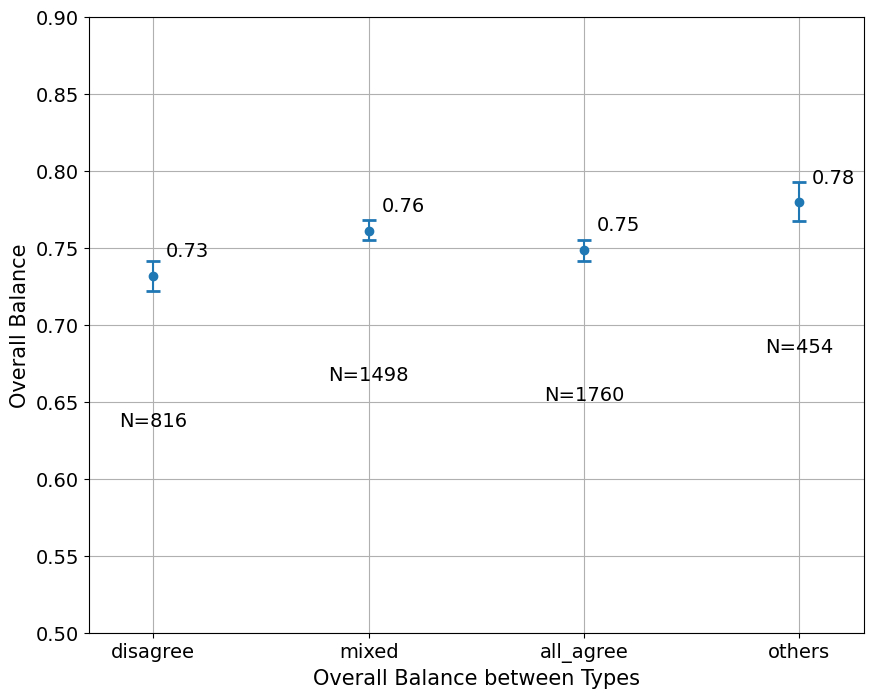

In [78]:
def plot_convo_vote_agreement_type_balance(input):
    x_label = ['disagree', 'mixed', 'all_agree', 'others']
    group1_meta, group2_meta, group3_meta, group4_meta = input[x_label[0]], input[x_label[1]], input[x_label[2]], input[x_label[3]]
    group_length = [len(group1_meta), len(group2_meta), len(group3_meta), len(group4_meta)]
    y = [np.mean(group1_meta), np.mean(group2_meta), np.mean(group3_meta), np.mean(group4_meta)]
    y_err = [bootstrap_95(group1_meta), bootstrap_95(group2_meta), 
             bootstrap_95(group3_meta), bootstrap_95(group4_meta)]
    lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
    upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
    asymmetric_error = [lower_errors, upper_errors]
    plt.figure(figsize=(10, 8))
    plt.errorbar(x_label, y, yerr=asymmetric_error, fmt='o', capsize=5, capthick=2)
    plt.xlabel('Overall Balance between Types', fontsize=15)
    plt.ylabel(f'Overall Balance', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0.5, 0.9)
    plt.xlim(-0.3, len(x_label)-0.7)
    for i, value in enumerate(y):
        plt.text(i+0.16, value+0.01, f"{str(round(value, 2))}", ha='center', va='bottom')
    for i, value in enumerate(y):
        plt.text(i, value-0.1, f"N={group_length[i]}", ha='center', va='bottom')
    plt.grid(True)
    
    plt.show()

plot_convo_vote_agreement_type_balance(convo_vote_agreement_type_balance)

In [79]:
def check_if_lawyer_win(corpus, convo_id):
    convo = corpus.get_conversation(convo_id)
    win_side = convo.meta['win_side']
    lawyer_side = -1
    for utt in convo.iter_utterances():
        if utt.meta['speaker_type'] == 'A':
            lawyer_side = utt.meta['side']
    if lawyer_side == -1:
        print(convo_id)
    return win_side == lawyer_side

for convo in cur_corpus.iter_conversations():
    win = check_if_lawyer_win(cur_corpus, convo.id)
    convo.meta['lawyer_win'] = win

In [80]:
triangle_types = ["dominating_throughout", "back_and_forth", "interleaved", "no_label"]
case_agreement_types = ['disagree', 'all_agree']
cases_agreement_triangle_matrix = {}
for case in case_agreement_types:
    cases_agreement_triangle_matrix.update({case : {}})
    for type in triangle_types:
        cases_agreement_triangle_matrix[case].update({type : []})

for convo in cur_corpus.iter_conversations():
    case = convo.meta['agreement_type']
    type = convo.meta['triangle_type']
    if case == 'disagree' or case == 'all_agree':
        cases_agreement_triangle_matrix[case][type].append(convo.id)

cases_agreement_triangle_matrix_lawyer_win = {}
for case, type_dict in cases_agreement_triangle_matrix.items():
    cases_agreement_triangle_matrix_lawyer_win.update({case : {}})
    for type, convo_id_lst in type_dict.items():
        cases_agreement_triangle_matrix_lawyer_win[case].update({type : []})
        for convo_id in convo_id_lst:
            convo = cur_corpus.get_conversation(convo_id)
            cases_agreement_triangle_matrix_lawyer_win[case][type].append(convo.meta['lawyer_win'])

win_rates = {}
for case, type_dict in cases_agreement_triangle_matrix_lawyer_win.items():
    win_rates[case] = {}
    for type, win_list in type_dict.items():
        if len(win_list) > 0:
            win_rate = sum(win_list) / len(win_list)
        else:
            win_rate = -1
        win_rates[case][type] = win_rate

We applied our talk-time dynamics framework to Supreme Court Oral Arguments and found that conversational dynamics---the degree of dominance or balance between justices and lawyers and the stereotype of conversation—--correlate with case outcomes, such as whether the final decision was unanimous or divided.

In [81]:
win_case_disagree = [convo.meta['lawyer_win'] for convo in cur_corpus.iter_conversations() if convo.meta['agreement_type'] == 'disagree']
win_case_all_agree = [convo.meta['lawyer_win'] for convo in cur_corpus.iter_conversations() if convo.meta['agreement_type'] == 'all_agree']

print(f"For divided decision conversations, lawyer win rate is {win_case_disagree.count(True)/len(win_case_disagree)}")
print(f"For unanimous decision conversations, lawyer win rate is {win_case_all_agree.count(True)/len(win_case_all_agree)}")

For divided decision conversations, lawyer win rate is 0.5845588235294118
For unanimous decision conversations, lawyer win rate is 0.6357954545454545


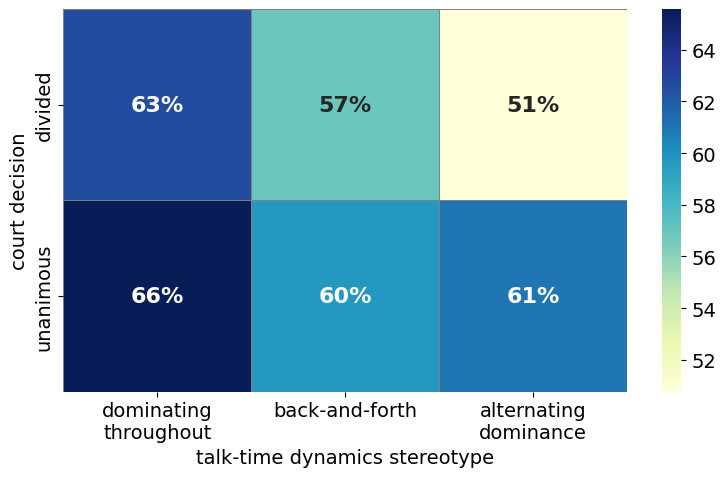

In [ ]:
plot_data_dict = {}
for case, type_dict in win_rates.items():
    if case == 'all_agree': case = 'unanimous'
    elif case == 'disagree': case = 'divided'
    for type, win_rate in type_dict.items():
        if type == 'dominating_throughout': type = 'dominating\nthroughout'
        elif type == 'back_and_forth': type = 'back-and-forth'
        elif type == 'interleaved': type = 'alternating\ndominance'
        if type == 'no_label': continue
        if case not in plot_data_dict:
            plot_data_dict[case] = {}
        plot_data_dict[case][type] = win_rate * 100

df = pd.DataFrame(plot_data_dict).T.fillna(0)
plt.figure(figsize=(8, 5))
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, linewidths=.5, linecolor='grey', annot_kws={"size": 16, "weight": "bold"})
for text in ax.texts:
    value = float(text.get_text())
    text.set_text(f'{value:.0f}%')
plt.xlabel('talk-time dynamics stereotype')
plt.ylabel('court decision')
plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig('heatmap_convo2.png', dpi=300, bbox_inches='tight')
plt.show()